This notebook goes through how I'm parsing the data one step at a time, for Patient GF101, Insulin1, Aug24-31. Hopefully I'll be able to get to the plotted graph by the end of this notebook.

In [1]:
import pandas as pd
import numpy as np
import sys

u_cols = ['Date', 'Time', 'Timestamp', 'Bolus Type', 'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)', 'Sensor Glucose (mg/dL)']
filename = '670GF109_Insulin1_Carelink_OCT05-12.csv'

data = pd.read_csv(
                    filename, 
                    skiprows=range(11),
                    usecols=u_cols,
                    )

# drop all the rows that don't give us any valuable information regarding blood glucose and insulin boluses
data = data.dropna(thresh=4)
data = data.reset_index()

I've loaded the csv into the DataFrame "data" using only the columns I deemed necessary. I also got rid of the first few rows because they aren't formatted the same way that the rest of the file is.

In [2]:
# off by one -- on Excel file indexing starts with 1, but indexing starts with 0 on pandas
data.head()

,index,Date,Time,Timestamp,Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Sensor Glucose (mg/dL)
0,12,10/5/18,00:00:07,10/5/18 00:00:07,NaN,NaN,NaN,215.0
1,17,10/5/18,00:00:16,10/5/18 00:00:16,Normal,0.05,0.05,NaN
2,23,10/5/18,00:05:07,10/5/18 00:05:07,NaN,NaN,NaN,221.0
3,28,10/5/18,00:05:15,10/5/18 00:05:15,Normal,0.05,0.05,NaN
4,34,10/5/18,00:10:07,10/5/18 00:10:07,NaN,NaN,NaN,221.0


Note that the cells that don't contain any values in Excel are shown as "Not a Number" in pandas. I used integer-location based indexing to make sure that the bolus volumes that I need are in the DataFrame.

There's a lot of waste data in the csv files, specifically the days when the patient is not on their meal challenge. Thankfully, there's an Excel file with dates during which the subjects are on their meal challenges.

In [3]:
from pandas import ExcelFile

# for this specific patient, 670GF101, the meal dates for Insulin 1 were from 8/29 to 8/31
# the first and second row contain column names, so we skip those
ex = pd.read_excel(
                    '670G Fiasp Subject Dates.xlsx', 
                    sheet_name='Sheet1', 
                    skiprows=range(1)
                    )

ex.head()

,Subject ID,Week 1,Week 2,Meal Dates,Week 1.1,Week 2.1,Meal Dates.1
0,670GF101,2018-08-17,2018-08-24,08/29-08/31,2018-08-31,2018-09-07,09/11-09/13
1,670GF102,2018-08-17,2018-08-24,08/21-08/23,2018-08-31,2018-09-07,09/11-09/13
2,670GF103,2018-08-17,2018-08-24,08/21-08/23,2018-08-31,2018-09-07,09/11-09/13
3,670GF104,2018-08-29,2018-09-06,09/11-09-13,2018-09-13,2018-09-20,09/24-09/26
4,670GF105,2018-09-06,2018-09-13,09/17-09/19,2018-09-20,2018-09-27,10/01-10/03


In [4]:
start = ""
end = ""

# iterate through the first column to match patient name
for row in ex.itertuples():
    # the first element in each row/tuple will be the index
    if row[1] == filename[:8]:
        if filename[9:17] == 'Insulin1':
            start = row[4][0:5]
            end = row[4][6:]
        elif filename[9:17] == 'Insulin2':
            start = row[7][0:5]
            end = row[7][6:]
        
# add years
start += "/18"
end += "/18"
        
print(start,end) 

10/09/18 10/11/18


Now I can just check for these dates within in the DataFrame "data", and then remove all the values that are not associated with those dates.

In [5]:
import datetime
from datetime import datetime, time, timedelta

# convert start and end into datetime objects
start = datetime.strptime(start, "%m/%d/%y")
end = datetime.strptime(end, "%m/%d/%y")

print (start, end)

data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_datetime(data['Time']).dt.time
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data.head()

2018-10-09 00:00:00 2018-10-11 00:00:00


,index,Date,Time,Timestamp,Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Sensor Glucose (mg/dL)
0,12,2018-10-05,00:00:07,2018-10-05 00:00:07,NaN,NaN,NaN,215.0
1,17,2018-10-05,00:00:16,2018-10-05 00:00:16,Normal,0.05,0.05,NaN
2,23,2018-10-05,00:05:07,2018-10-05 00:05:07,NaN,NaN,NaN,221.0
3,28,2018-10-05,00:05:15,2018-10-05 00:05:15,Normal,0.05,0.05,NaN
4,34,2018-10-05,00:10:07,2018-10-05 00:10:07,NaN,NaN,NaN,221.0


After converting all dates to a datetime object, we can iterate through and see which dates are within the range we want.

In [6]:
start_date = start
end_date = end + timedelta(days=1)
print(end_date)

start_row = 0
end_row = 0

# track index of the first occurrence of our start date and the last occurrence of our end date
# e.g. the first occurrence of the end date + 1
for index, row in data.iterrows():
    if row[1] == start_date:
        start_row = index
        break
for index, row in data.iterrows():
    if row[1] == end_date:
        end_row = index
        break
        
# last date on csv was the last date of meal trial
if end_row == 0:
    end_row = data.tail(1).index.item()
    
print(start_row, end_row)


2018-10-12 00:00:00
1288 2605


Get rid of all the junk dates we don't need to look at.

In [7]:
data_extracted = data[start_row:end_row]
data_extracted.head()

,index,Date,Time,Timestamp,Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Sensor Glucose (mg/dL)
1288,12302,2018-10-09,00:03:47,2018-10-09 00:03:47,NaN,NaN,NaN,140.0
1289,12312,2018-10-09,00:08:47,2018-10-09 00:08:47,NaN,NaN,NaN,144.0
1290,12322,2018-10-09,00:13:47,2018-10-09 00:13:47,NaN,NaN,NaN,142.0
1291,12332,2018-10-09,00:18:47,2018-10-09 00:18:47,NaN,NaN,NaN,136.0
1292,12342,2018-10-09,00:23:47,2018-10-09 00:23:47,NaN,NaN,NaN,130.0


We should segment our meal period into three separate days, breakfast and dinner, then gather statistics about them individually. This notebook will focus on dinner.

In [8]:
data_day1 = data_extracted[data_extracted.Date == start]
data_day2 = data_extracted[data_extracted.Date == start + timedelta(days=1)]
data_day3 = data_extracted[data_extracted.Date == end]

dates = [data_day1, data_day2, data_day3]

# create an array of dates that have only glucose values
data_day1_glucose_graph = data_day1.dropna(subset=['Sensor Glucose (mg/dL)'])
data_day2_glucose_graph = data_day2.dropna(subset=['Sensor Glucose (mg/dL)'])
data_day3_glucose_graph = data_day3.dropna(subset=['Sensor Glucose (mg/dL)'])

dates_glucose_graph = [data_day1_glucose_graph, data_day2_glucose_graph, data_day3_glucose_graph]

Just graph out data first!

(0, 300)

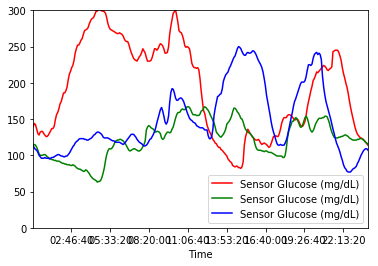

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = dates_glucose_graph[0].plot(kind='line', x='Time', y='Sensor Glucose (mg/dL)', color='red')
dates_glucose_graph[1].plot(ax=ax, kind='line', x='Time', y='Sensor Glucose (mg/dL)', color='green')
dates_glucose_graph[2].plot(ax=ax, kind='line', x='Time', y='Sensor Glucose (mg/dL)', color='blue')
plt.ylim(0,300)

For each day, we want to gather the breakfast bolus metric, the time the bolus is taken, etc. We also have to keep in mind that some breakfasts will have to be thrown out if there's another bolus within 3 hours of the breakfast bolus.

Results were recorded in order of [bolus, bolus_time, baseline_glucose, glucose_max, delta_max, T_max, glucose_min, delta_min, T_min, T_halfmax].

Once we have a DataFrame for each meal (breakfast_period), starting with the initial breakfast bolus and ending after an hour and a half, we can scale all glucose values according to the baseline glucose and all timestamps according to the time the insulin bolus was delivered.

(0, 300)

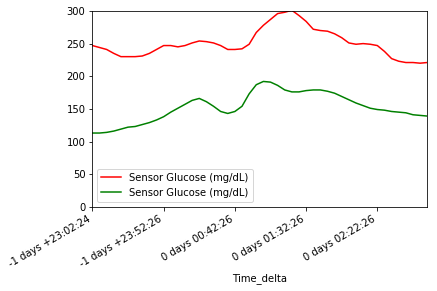

In [10]:
# just graph out an hour before and 3 hours after the initial bolus to see what the curves would look like
to_graph = []

for day in dates:
    bolus_time = time(0,0,0) # will become datetime later
    bolus_index = 0
    
    # find when the breakfast bolus is
    for index, row in day.iterrows():
    # if time of the row is in between 6:00:00 and 10:00:00, and the bolus amount is larger than 1
        if row['Time'] <= time(10, 0, 0) and row['Time'] >= time(6, 0, 0) and row['Bolus Volume Selected (U)'] >= 1 and row['Bolus Volume Delivered (U)'] >= 1: 
            bolus_time = row['Timestamp']
            bolus_index = index
            graph = (day[(day['Timestamp'] <= (day.loc[bolus_index]['Timestamp'] + timedelta(hours=3))) &
                          (day['Timestamp'] >= (day.loc[bolus_index]['Timestamp'] - timedelta(hours=1)))])
            graph = graph.dropna(subset=['Sensor Glucose (mg/dL)'])
            graph['Time_delta'] = graph['Timestamp'] - bolus_time
            to_graph.append(graph)
            
    
ax = to_graph[0].plot(kind='line', x='Time_delta', y='Sensor Glucose (mg/dL)', color='red')     
to_graph[1].plot(ax=ax, kind='line', x='Time_delta', y='Sensor Glucose (mg/dL)', color='green')
#to_graph[2].plot(ax=ax, kind='line', x='Time_delta', y='Sensor Glucose (mg/dL)', color='blue')
plt.ylim(0,300)
    
            

In [11]:
"""
# day 1 has a sensor error b/c calibration wasn't conducted in time
# watch out for day 3, that should be eliminated! one bolus @ 7:58:54 and another @ 8:53:05

breakfasts = []
results = []

for day in dates:
    bolus = 0
    bolus_time = time(0,0,0)
    baseline_glucose = 0
    bolus_index = 0
    possible_baseline_glucoses = []
    second_bolus_found = False
    
    # get the breakfast bolus metric -- should be from 6 am to 10 am
    for index, row in day.iterrows():
        if second_bolus_found:
            bolus = 0
            bolus_time = time(0, 0, 0)
            baseline_glucose = 0
            possible_baseline_glucoses = []
            break
        
        # if time of the row is in between 6:00:00 and 10:00:00, and the bolus amount is larger than 1
        if row['Time'] <= time(10, 0, 0) and row['Time'] >= time(6, 0, 0) and row['Bolus Volume Selected (U)'] >= 1 and row['Bolus Volume Delivered (U)'] >= 1: 
            # check if there's already been a bolus registered -- in that case, skip this day
            if bolus > 0:
                second_bolus_found = True
            # if not, record the metric, timestamp, and glucose level at that time
            else:
                bolus = row['Bolus Volume Delivered (U)']
                bolus_time = row['Timestamp']
                bolus_index = index
                # glucose_baseline must be within 20 minutes beforehand or 5 minutes after the bolus
                possible_baseline_glucoses = day[(day['Timestamp'] >= (row['Timestamp'] - timedelta(minutes=20))) & 
                                      (day['Timestamp'] <= (row['Timestamp'] + timedelta(minutes=5))) & 
                                      ((day['Sensor Glucose (mg/dL)']).isnull() == False)]
            
        if row['Time'] > time(10, 0, 0):
            break

    min_time_diff = timedelta.max
    # for each possible baseline value, check which timestamp is closest to insulin bolus time
    if not second_bolus_found:
        for index, possible_baseline in possible_baseline_glucoses.iterrows():
            # using time objects instead of datetime objects b/c looping through different days
            time_diff = abs(datetime.combine(datetime.min, possible_baseline['Time']) - datetime.combine(datetime.min, bolus_time.time()))
            if time_diff < min_time_diff:
                min_time_diff = time_diff
                baseline_glucose = possible_baseline['Sensor Glucose (mg/dL)']
    else:
        # TODO: what to do for results of N/A dates?
        break
  
    # within the next 1:30, we need to look for the maximum glucose level, minimum glucose level,
    # don't forget to record the T_max and T_1/2max
    glucose_max = 0
    delta_max = 0
    T_max = 0
    glucose_min = sys.maxsize
    delta_min = 0
    T_min = 0
    T_halfmax = 0
    
    breakfast_period = day[(day['Timestamp'] <= (day.loc[bolus_index]['Timestamp'] + timedelta(hours=1, minutes=30))) &
                          (day['Timestamp'] >= day.loc[bolus_index]['Timestamp'])]
    
    for index, entry in breakfast_period.iterrows():
        if entry['Sensor Glucose (mg/dL)'] > glucose_max:
            glucose_max = entry['Sensor Glucose (mg/dL)']
            T_max = entry['Timestamp']
        if entry['Sensor Glucose (mg/dL)'] < glucose_min:
            glucose_min = entry['Sensor Glucose (mg/dL)']
            T_min = entry['Timestamp']
            
    delta_max = glucose_max - baseline_glucose
    delta_min = glucose_min - baseline_glucose
    
    glucose_halfmax = baseline_glucose + delta_max / 2
    for index, entry in breakfast_period.iterrows():
        # captures the first instance of a glucose reading at 1/2 max
        if (entry['Sensor Glucose (mg/dL)'] <= glucose_halfmax + 1) or (entry['Sensor Glucose (mg/dL)'] >= glucose_halfmax - 1):
            T_halfmax = entry['Timestamp']
            break
    
    result = [bolus, bolus_time, baseline_glucose, glucose_max, delta_max, T_max, glucose_min, delta_min, T_min, T_halfmax]
    results.append(result)
    
    # add new columns 'Glucose_delta' and 'Time-delta' to plot later on
    # TODO: deal with warning
    breakfast_period['Time_delta'] = breakfast_period['Timestamp'] - bolus_time
    breakfast_period['Glucose_delta'] = breakfast_period['Sensor Glucose (mg/dL)'] - baseline_glucose
    
    breakfasts.append(breakfast_period)
"""
    

"\n# day 1 has a sensor error b/c calibration wasn't conducted in time\n# watch out for day 3, that should be eliminated! one bolus @ 7:58:54 and another @ 8:53:05\n\nbreakfasts = []\nresults = []\n\nfor day in dates:\n    bolus = 0\n    bolus_time = time(0,0,0)\n    baseline_glucose = 0\n    bolus_index = 0\n    possible_baseline_glucoses = []\n    second_bolus_found = False\n    \n    # get the breakfast bolus metric -- should be from 6 am to 10 am\n    for index, row in day.iterrows():\n        if second_bolus_found:\n            bolus = 0\n            bolus_time = time(0, 0, 0)\n            baseline_glucose = 0\n            possible_baseline_glucoses = []\n            break\n        \n        # if time of the row is in between 6:00:00 and 10:00:00, and the bolus amount is larger than 1\n        if row['Time'] <= time(10, 0, 0) and row['Time'] >= time(6, 0, 0) and row['Bolus Volume Selected (U)'] >= 1 and row['Bolus Volume Delivered (U)'] >= 1: \n            # check if there's alrea

Finally, we can plot them on the same graph.

In [12]:
plt.figure()

breakfast_period_graph_0 = breakfasts[0].dropna(subset=['Glucose_delta'])
ax = breakfast_period_graph_0.plot(kind='line', x='Time_delta', y='Glucose_delta')
for i in range(1, len(breakfasts)):
    breakfast_period_graph = breakfasts[i].dropna(subset=['Glucose_delta'])
    breakfast_period_graph.plot(ax=ax, kind='line', x='Time_delta', y='Glucose_delta')

NameError: name 'breakfasts' is not defined